In [1]:
import sys
import numpy as np
import uproot
import hist
import awkward as ak

import tritonclient.grpc as grpcclient
from tritonclient.utils import InferenceServerException

from coffea import processor
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from coffea.nanoevents.methods import base

# DEMO: First steps using Triton inference server at coffea-casa facility
__________

To demonstrate the current functionality of inference with Triton at the coffea-casa OD facility, a simple example was developed. Toy "events", each with four randomly generated observables, were created from signal and background classes. The comparison of background and signal distributions can be seen below:
![alt text](images/toydata_truth.png "Histograms of Toy Data Variables")

This data was used to train a simple neural network in PyTorch to classify an event as either signal or background, when given the four input variables. The architecture of this network is shown below. With this simple model architecture, the network achieves around 97\% accuracy.
![alt text](images/binary_classifier.png "Neural Network Architecture")

In order to use this PyTorch model for inference in the Triton server, there are a few steps that need to be taken.

1. The model needs to be a ScriptModule (torch.jit.ScriptModule). This is an analog to torch.nn.Module and is a wrapper around C++. For simple models, such as the one used in this example, this can be done by the command `model = torch.jit.script(model)`.
2. Save the model using `torch.jit.save`
3. Create a directory for your model. For this facility, the directory should be placed in `/mnt`. The structure of the directory must be the following:
```text
        binary_classifier/
        ├── 1
        │   └── model.pt
        └── config.pbtxt
```

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The subdirectory `1` indicates the model version. You can have multiple versions. `1` contains the model file, which must be named `model.pt`, if using PyTorch.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;You must also create the config file. The structure of the config file used in this example is printed below. Variable names must be of the form `var__i`, where `i` is an integer. The name of the model in the config file much match the name of the model directory.
    
    
```
name: "binary_classifier"
platform: "pytorch_libtorch"
max_batch_size: 0
input [
  {
    name: "x__0"
    data_type: TYPE_FP32
    dims: [ -1, 4 ]
  }
]
output [
  {
    name: "logits__0"
    data_type: TYPE_FP32
    dims: [ -1, 1  ]
  }
]

dynamic_batching {}
```
4. You can check if the model is loaded by running `curl agc-triton-inference-server:8000/v2/models/{model_name}/config`. Let's check if our model is loaded:

In [2]:
!curl -v agc-triton-inference-server:8000/v2/models/binary_classifier/config

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
*   Trying 192.168.41.89:8000...
* Connected to agc-triton-inference-server (192.168.41.89) port 8000 (#0)
> GET /v2/models/binary_classifier/config HTTP/1.1
> Host: agc-triton-inference-server:8000
> User-Agent: curl/7.68.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< Content-Type: application/json
< Content-Length: 1077
< 
{"name":"binary_classifier","platform":"pytorch_libtorch","backend":"pytorch","version_policy":{"latest":{"num_versions":1}},"max_batch_size":0,"input":[{"name":"x__0","data_type":"TYPE_FP32","format":"FORMAT_NONE","dims":[-1,4],"is_shape_tensor":false,"allow_ragged_batch":false,"optional":false}],"output":[{"name":"logits__0","data_type":"TYPE_FP32","dims":[-1,1],"label_filename":"","is_shape_tensor":false}],"batch_input":[],"batch_output":[],"optimization":{"priority":"PRIORITY_DEFAULT","input_pinned_memory":{"enable":true},"output_pinned_memory

________
If you see `{"error":"Request for unknown model: 'binary_classifier' has no available versions"}`, the model needs to be loaded. You can load or unload models from the inference server using the following commands:

* Note: Loading/unloading models in this way may not work at the moment, so be careful!

In [3]:
#!curl -v -X POST agc-triton-inference-server:8000/v2/repository/models/binary_classifier/unload
#!curl -v -X POST agc-triton-inference-server:8000/v2/repository/models/binary_classifier/load

Now that we know the model is loaded, we can start setting up to perform inference!

In [4]:
# options for triton inference server
verbose     = False # enable verbose output for grpcclient
url         = "agc-triton-inference-server:8001" # url of inference server. use 8001 for grpcclient and 8000 for httpclient
model_name  = "binary_classifier" # name of ML model to use (make sure it is loaded properly)
model_vers  = "" # specify model version if necessary

# options for coffea
num_cores   = 4 # scaling for setup with FuturesExecutor

## Defining coffea processor

In [5]:
processor_base = processor.ProcessorABC

class SigBkgInference(processor_base):
    
    def __init__(self, model_name, model_vers, url, verbose):
        
        # histogram to store event variables and inference results
        self.hist = (hist.Hist.new.Reg(50, -7, 7, name="var0", label="Variable 0")
                     .Reg(50, -45, 5, name="var1", label="Variable 1")
                     .Reg(50, 0, 15, name="var2", label="Variable 2")
                     .IntCat(range(2), name="classification", label="ML Classification (Sig/Bkg)")
                     .Weight())
        
        # model information
        self.model_name = model_name
        self.model_vers = model_vers
        self.url = url
        self.verbose = verbose
        
    def process(self, events):
        
        histogram = self.hist.copy()
        
        # concatenate event variables (for input into neural network)
        features = np.vstack((events.var0, 
                              events.var1, 
                              events.var2, 
                              events.var3)).to_numpy().T.astype(np.float32)
        
        # create gRPC client (communicates with inference server)
        triton_client = grpcclient.InferenceServerClient(url=self.url, verbose=self.verbose)
        
        # get model info
        model_metadata = triton_client.get_model_metadata(self.model_name, self.model_vers)
        input_name = model_metadata.inputs[0].name
        dtype = model_metadata.inputs[0].datatype
        output_name = model_metadata.outputs[0].name
        
        # configure and set inputs
        client = grpcclient
        inpt = [client.InferInput(input_name, features.shape, dtype)]
        inpt[0].set_data_from_numpy(features)
        
        # configure output
        output = client.InferRequestedOutput(output_name)
        
        # inference request (uses dynamic batching)
        results = triton_client.infer(model_name=self.model_name, 
                                      inputs=inpt, 
                                      outputs=[output]).as_numpy(output_name)
        
        # round results to nearest integer and reshape
        classification = np.round(results).T[0].astype(int).tolist()
        
        triton_client.close() # close client
        
        # fill histogram
        histogram.fill(var0=events.var0, 
                       var1=events.var1, 
                       var2=events.var2, 
                       classification=classification)
            
        output = {"nevents": {events.metadata["dataset"]: features.shape[0]}, 
                  "hist": histogram}

        return output

    def postprocess(self, accumulator):
        return accumulator

## Defining schema to load toy data

In [6]:
class ToySchema(BaseSchema):
    
    def _build_collections(self, branch_forms):
        names = ["var0", "var1", "var2", "var3"]
        
        output = {}
        for name in names:
            output[name] = branch_forms[name]
        return output

## Process events

In [7]:
# paths to files
fileset = {'process0': {'files': ['data/testdata0.root',
                                  'data/testdata1.root',
                                  'data/testdata2.root',
                                  'data/testdata3.root',
                                  'data/testdata4.root',
                                  'data/testdata5.root',
                                  'data/testdata6.root',
                                  'data/testdata7.root',
                                  'data/testdata8.root',
                                  'data/testdata9.root'],
                        'nevts': 10*20000}
          }

In [8]:
executor = processor.FuturesExecutor(workers=num_cores)

In [9]:
run = processor.Runner(executor=executor, 
                       schema=ToySchema, 
                       savemetrics=True, 
                       metadata_cache={}, 
                       chunksize=500_000)

In [10]:
filemeta = run.preprocess(fileset, treename="events")

Output()

In [11]:
all_histograms, metrics = run(fileset, 
                              "events", 
                              processor_instance=SigBkgInference(model_name, 
                                                                 model_vers, 
                                                                 url, 
                                                                 verbose)
                             )

Output()

In [12]:
import matplotlib.pyplot as plt

In [13]:
all_histograms['hist']

Hist(
  Regular(50, -7, 7, name='var0', label='Variable 0'),
  Regular(50, -45, 5, name='var1', label='Variable 1'),
  Regular(50, 0, 15, name='var2', label='Variable 2'),
  IntCategory([0, 1], name='classification', label='ML Classification (Sig/Bkg)'),
  storage=Weight()) # Sum: WeightedSum(value=199932, variance=199932) (WeightedSum(value=200000, variance=200000) with flow)

## Now we can histogram the variables by predicted class! (Signal or Background)

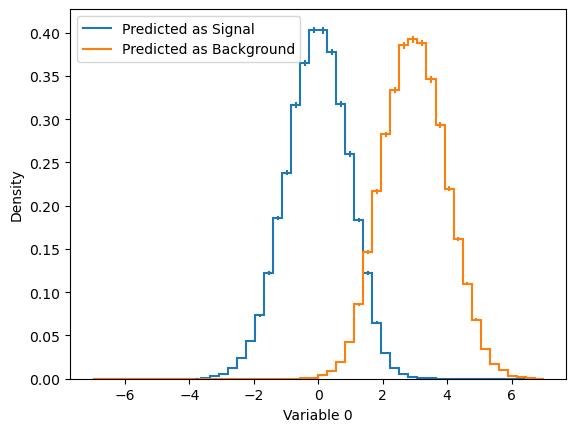

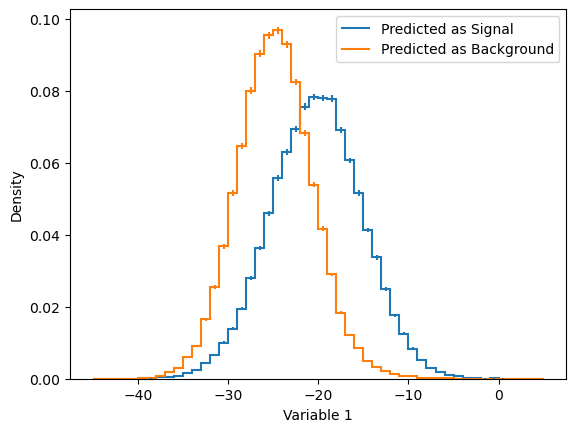

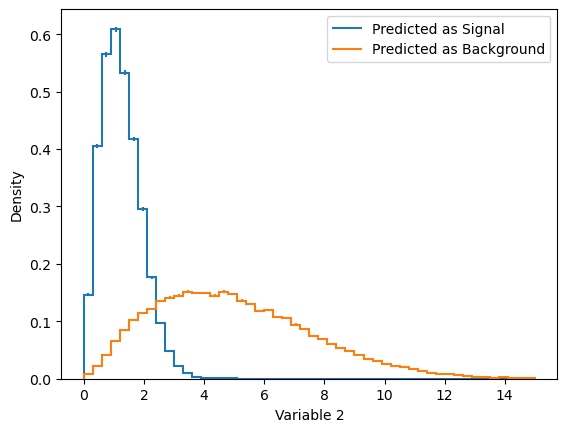

In [14]:
all_histograms['hist'].project("classification", "var0").plot(density=True)
plt.legend(["Predicted as Signal","Predicted as Background"])
plt.ylabel("Density")
plt.show()
all_histograms['hist'].project("classification", "var1").plot(density=True)
plt.legend(["Predicted as Signal","Predicted as Background"])
plt.ylabel("Density")
plt.show()
all_histograms['hist'].project("classification", "var2").plot(density=True)
plt.legend(["Predicted as Signal","Predicted as Background"])
plt.ylabel("Density")
plt.show()